In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [4]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [7]:
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [8]:
print('Load Main Data')
# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv('sales_train_validation.csv')
prices_df = pd.read_csv('sell_prices.csv')
calendar_df = pd.read_csv('calendar.csv')

Load Main Data


In [9]:
print('Create Grid')

# We can tranform horizontal representation 
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# If we look on train_df we se that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df), len(grid_df))

# To be able to make predictions
# we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df
# anymore and can remove it
del train_df

# You don't have to use df = df construction
# you can use inplace=True instead.
# like this
# grid_df.reset_index(drop=True, inplace=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Create Grid
Train rows: 30490 58327370
    Original grid_df:   3.5GiB
     Reduced grid_df:   1.3GiB


In [21]:
grid_df.head() #1-1913:train

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0


In [22]:
grid_df.tail() #1914-1941:test

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
59181085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,NaN


In [28]:
prices_df[(prices_df['store_id']=='CA_1') & (prices_df['item_id']=='FOODS_1_001')].head()

,store_id,item_id,wm_yr_wk,sell_price
368746,CA_1,FOODS_1_001,11101,2.0
368747,CA_1,FOODS_1_001,11102,2.0
368748,CA_1,FOODS_1_001,11103,2.0
368749,CA_1,FOODS_1_001,11104,2.0
368750,CA_1,FOODS_1_001,11105,2.0


In [23]:
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# absence for the item in the store
# we can safe some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']

Release week


In [24]:
release_df.head() # release: the first wm_yr_wk has price

,store_id,item_id,release
0,CA_1,FOODS_1_001,11101
1,CA_1,FOODS_1_002,11101
2,CA_1,FOODS_1_003,11101
3,CA_1,FOODS_1_004,11206
4,CA_1,FOODS_1_005,11101


In [29]:
# Now we can merge release_df
grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
del release_df

In [30]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,11101
32102,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,11101
62592,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,11101
93082,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,11101
123572,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,11101


In [31]:
# We want to remove some "zeros" rows
# from grid_df 
# to do it we need wm_yr_wk column
# let's merge partly calendar_df to have it
grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])

In [32]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,11101,11101
32102,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,11101,11101
62592,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,11101,11101
93082,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,11101,11101
123572,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,11101,11101


In [33]:
grid_df.shape

(59181090, 10)

In [34]:
# Now we can cutoff some rows 
# and safe memory 
grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

    Original grid_df:   1.7GiB


In [35]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
576,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,11101,11101
11508,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,11101,11101
22440,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,11101,11101
33372,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,11101,11101
44304,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,11101,11101


In [36]:
grid_df.shape

(46881677, 10)

In [37]:
# Should we keep release week 
# as one of the features?
# Only good CV can give the answer.
# Let's minify the release values.
# Min transformation will not help here 
# as int16 -> Integer (-32768 to 32767)
# and our grid_df['release'].max() serves for int16
# but we have have an idea how to transform 
# other columns in case we will need it
grid_df['release'] = grid_df['release'] - grid_df['release'].min()
grid_df['release'] = grid_df['release'].astype(np.int16)

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

     Reduced grid_df:   1.5GiB


In [38]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
576,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,0,11101
11508,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,0,11101
22440,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,0,11101
33372,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,0,11101
44304,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,0,11101


In [39]:
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
grid_df.to_pickle('grid_part_1.pkl')

print('Size:', grid_df.shape)

Save Part 1
Size: (46881677, 10)


In [41]:
# add price feature
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


In [42]:
print('Prices')

# We can do some basic aggregations
prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# and do price normalization (min/max scaling)
prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

Prices


In [43]:
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213
5,CA_1,HOBBIES_1_001,11330,8.26,9.58,8.26,0.152139,8.285714,0.862213
6,CA_1,HOBBIES_1_001,11331,8.26,9.58,8.26,0.152139,8.285714,0.862213
7,CA_1,HOBBIES_1_001,11332,8.26,9.58,8.26,0.152139,8.285714,0.862213
8,CA_1,HOBBIES_1_001,11333,8.26,9.58,8.26,0.152139,8.285714,0.862213
9,CA_1,HOBBIES_1_001,11334,8.26,9.58,8.26,0.152139,8.285714,0.862213


In [44]:
# Some items are can be inflation dependent
# and some items are very "stable"
# check how many unique values each group has
prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

In [45]:
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000,3.0,3
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000,3.0,3
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5
5,CA_1,HOBBIES_1_001,11330,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5
6,CA_1,HOBBIES_1_001,11331,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5
7,CA_1,HOBBIES_1_001,11332,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5
8,CA_1,HOBBIES_1_001,11333,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5
9,CA_1,HOBBIES_1_001,11334,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5


In [46]:
# I would like some "rolling" aggregations
# but would like months and years as "window"
calendar_prices = calendar_df[['wm_yr_wk','month','year']]
calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
del calendar_prices

# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

del prices_df['month'], prices_df['year']

In [47]:
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000,3.0,3,NaN,1.127059,1.145166
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000,3.0,3,1.000000,1.127059,1.145166
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,0.862213,0.971765,0.987377
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,1.000000,1.000000,0.987377
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,1.000000,1.000000,0.987377
5,CA_1,HOBBIES_1_001,11330,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,1.000000,1.000000,0.987377
6,CA_1,HOBBIES_1_001,11331,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,1.000000,1.000000,0.987377
7,CA_1,HOBBIES_1_001,11332,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,1.000000,1.000000,0.987377
8,CA_1,HOBBIES_1_001,11333,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,1.000000,1.000000,0.987377
9,CA_1,HOBBIES_1_001,11334,8.26,9.58,8.26,0.152139,8.285714,0.862213,3.0,5,1.000000,1.000000,0.987377


In [48]:
print('Merge prices and save part 2')

# Merge Prices
original_columns = list(grid_df)
grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(grid_df) if col not in original_columns]
grid_df = grid_df[MAIN_INDEX+keep_columns]
grid_df = reduce_mem_usage(grid_df)

# Safe part 2
grid_df.to_pickle('grid_part_2.pkl')
print('Size:', grid_df.shape)

# We don't need prices_df anymore
del prices_df

Merge prices and save part 2
Mem. usage decreased to 1789.88 Mb (62.2% reduction)
Size: (46881677, 13)


In [49]:
grid_df.head()

,id,d,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,HOBBIES_1_008_CA_1_validation,d_1,0.459961,0.500000,0.419922,0.019760,0.476318,0.919922,4.0,16,NaN,0.968750,0.949219
1,HOBBIES_1_009_CA_1_validation,d_1,1.559570,1.769531,1.559570,0.032745,1.764648,0.881348,2.0,9,NaN,0.885742,0.896484
2,HOBBIES_1_010_CA_1_validation,d_1,3.169922,3.169922,2.970703,0.046356,2.980469,1.000000,2.0,20,NaN,1.064453,1.043945
3,HOBBIES_1_012_CA_1_validation,d_1,5.980469,6.519531,5.980469,0.115967,6.468750,0.916992,3.0,71,NaN,0.921875,0.958984
4,HOBBIES_1_015_CA_1_validation,d_1,0.700195,0.720215,0.680176,0.011337,0.706543,0.972168,3.0,16,NaN,0.990234,1.001953


In [50]:
# add calender feature
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [51]:
grid_df = pd.read_pickle('grid_part_1.pkl')

In [52]:
grid_df = grid_df[MAIN_INDEX]

# Merge calendar partly
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']

grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

# Minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']
for col in icols:
    grid_df[col] = grid_df[col].astype('category')

# Convert to DateTime
grid_df['date'] = pd.to_datetime(grid_df['date'])

# Make some features from date
grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8) #day of month
grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8) # week of year
grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8) # month of year
grid_df['tm_y'] = grid_df['date'].dt.year # year
grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8) # minus min(year)
grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8) # week of month

grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8) # day of week: monday start from 0, so saturday. is 5
grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8) # weekend and weekday

# Remove date
del grid_df['date']

In [53]:
grid_df.head()

,id,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,tm_d,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,HOBBIES_1_008_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
1,HOBBIES_1_009_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
2,HOBBIES_1_010_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
3,HOBBIES_1_012_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
4,HOBBIES_1_015_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1


In [54]:
print('Save part 3')

# Safe part 3
grid_df.to_pickle('grid_part_3.pkl')
print('Size:', grid_df.shape)

# We don't need calendar_df anymore
del calendar_df
del grid_df

Save part 3
Size: (46881677, 16)


In [55]:
## Part 1
# Convert 'd' to int
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)

# Remove 'wm_yr_wk'
del grid_df['wm_yr_wk']
grid_df.to_pickle('grid_part_1.pkl')

del grid_df

In [56]:
# Now we have 3 sets of features
grid_df = pd.concat([pd.read_pickle('grid_part_1.pkl'),
                     pd.read_pickle('grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
                     
# Let's check again memory usage
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
print('Size:', grid_df.shape)

           Full Grid:   2.4GiB
Size: (46881677, 34)


In [57]:
# add lag feature
grid_df = pd.read_pickle('grid_part_1.pkl')

# We need only 'id','d','sales'
# to make lags and rollings
grid_df = grid_df[['id','d','sales']]
SHIFT_DAY = 28

In [58]:
# Lags
# with 28 day shift
start_time = time.time()
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,30,60,180]:
    print('Rolling period:', i)
    grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create lags
5.25 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60
Rolling period: 180
Shifting period: 1
Shifting period: 7
Shifting period: 14
10.99 min: Lags


In [59]:
grid_df[grid_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:60]

,id,d,sales,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,...,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60
16838178,HOBBIES_1_001_CA_1_validation,897,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16862809,HOBBIES_1_001_CA_1_validation,898,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16887440,HOBBIES_1_001_CA_1_validation,899,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16912071,HOBBIES_1_001_CA_1_validation,900,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16936702,HOBBIES_1_001_CA_1_validation,901,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16961333,HOBBIES_1_001_CA_1_validation,902,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16985964,HOBBIES_1_001_CA_1_validation,903,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17010595,HOBBIES_1_001_CA_1_validation,904,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17035335,HOBBIES_1_001_CA_1_validation,905,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17060075,HOBBIES_1_001_CA_1_validation,906,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 40 columns):
id                        category
d                         int16
sales                     float64
sales_lag_28              float16
sales_lag_29              float16
sales_lag_30              float16
sales_lag_31              float16
sales_lag_32              float16
sales_lag_33              float16
sales_lag_34              float16
sales_lag_35              float16
sales_lag_36              float16
sales_lag_37              float16
sales_lag_38              float16
sales_lag_39              float16
sales_lag_40              float16
sales_lag_41              float16
sales_lag_42              float16
rolling_mean_7            float16
rolling_std_7             float16
rolling_mean_14           float16
rolling_std_14            float16
rolling_mean_30           float16
rolling_std_30            float16
rolling_mean_60           float16
rolling_std_60            float16
ro

In [60]:
print('Save lags and rollings')
grid_df.to_pickle('lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


In [62]:
# group aggregation
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df[TARGET][grid_df['d']>(1913-28)] = np.nan
base_cols = list(grid_df)

icols =  [
            ['state_id'],
            ['store_id'],
            ['cat_id'],
            ['dept_id'],
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
            ]

for col in icols:
    print('Encoding', col)
    col_name = '_'+'_'.join(col)+'_'
    grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)[TARGET].transform('mean').astype(np.float16)
    grid_df['enc'+col_name+'std'] = grid_df.groupby(col)[TARGET].transform('std').astype(np.float16)

keep_cols = [col for col in list(grid_df) if col not in base_cols]
grid_df = grid_df[['id','d']+keep_cols]

Encoding ['state_id']
Encoding ['store_id']
Encoding ['cat_id']
Encoding ['dept_id']
Encoding ['state_id', 'cat_id']
Encoding ['state_id', 'dept_id']
Encoding ['store_id', 'cat_id']
Encoding ['store_id', 'dept_id']
Encoding ['item_id']
Encoding ['item_id', 'state_id']
Encoding ['item_id', 'store_id']


In [63]:
grid_df[grid_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:60]

,id,d,enc_state_id_mean,enc_state_id_std,enc_store_id_mean,enc_store_id_std,enc_cat_id_mean,enc_cat_id_std,enc_dept_id_mean,enc_dept_id_std,...,enc_store_id_cat_id_mean,enc_store_id_cat_id_std,enc_store_id_dept_id_mean,enc_store_id_dept_id_std,enc_item_id_mean,enc_item_id_std,enc_item_id_state_id_mean,enc_item_id_state_id_std,enc_item_id_store_id_mean,enc_item_id_store_id_std
16838178,HOBBIES_1_001_CA_1_validation,897,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16862809,HOBBIES_1_001_CA_1_validation,898,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16887440,HOBBIES_1_001_CA_1_validation,899,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16912071,HOBBIES_1_001_CA_1_validation,900,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16936702,HOBBIES_1_001_CA_1_validation,901,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16961333,HOBBIES_1_001_CA_1_validation,902,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16985964,HOBBIES_1_001_CA_1_validation,903,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
17010595,HOBBIES_1_001_CA_1_validation,904,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
17035335,HOBBIES_1_001_CA_1_validation,905,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
17060075,HOBBIES_1_001_CA_1_validation,906,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402


In [65]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 24 columns):
id                           category
d                            int16
enc_state_id_mean            float16
enc_state_id_std             float16
enc_store_id_mean            float16
enc_store_id_std             float16
enc_cat_id_mean              float16
enc_cat_id_std               float16
enc_dept_id_mean             float16
enc_dept_id_std              float16
enc_state_id_cat_id_mean     float16
enc_state_id_cat_id_std      float16
enc_state_id_dept_id_mean    float16
enc_state_id_dept_id_std     float16
enc_store_id_cat_id_mean     float16
enc_store_id_cat_id_std      float16
enc_store_id_dept_id_mean    float16
enc_store_id_dept_id_std     float16
enc_item_id_mean             float16
enc_item_id_std              float16
enc_item_id_state_id_mean    float16
enc_item_id_state_id_std     float16
enc_item_id_store_id_mean    float16
enc_item_id_store_id_std     float1

In [64]:
print('Save Mean/Std encoding')
grid_df.to_pickle('mean_encoding_df.pkl')

Save Mean/Std encoding


In [3]:
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [4]:
N_CORES = psutil.cpu_count()     # Available CPU cores

#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows if needed(Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon

In [16]:
#PATHS for Features
BASE     = 'grid_part_1.pkl'
PRICE    = 'grid_part_2.pkl'
CALENDAR = 'grid_part_3.pkl'
LAGS     = 'lags_df_28.pkl'
MEAN_ENC = 'mean_encoding_df.pkl'

In [6]:
grid_df = pd.concat([pd.read_pickle(BASE),
                pd.read_pickle(PRICE).iloc[:,2:],
                pd.read_pickle(CALENDAR).iloc[:,2:]],
                axis=1)

In [7]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 34 columns):
id                  category
item_id             category
dept_id             category
cat_id              category
store_id            category
state_id            category
d                   int16
sales               float64
release             int16
sell_price          float16
price_max           float16
price_min           float16
price_std           float16
price_mean          float16
price_norm          float16
price_nunique       float16
item_nunique        int16
price_momentum      float16
price_momentum_m    float16
price_momentum_y    float16
event_name_1        category
event_type_1        category
event_name_2        category
event_type_2        category
snap_CA             category
snap_TX             category
snap_WI             category
tm_d                int8
tm_w                int8
tm_m                int8
tm_y                int8
tm_wm               in

In [8]:
df2 = pd.read_pickle(MEAN_ENC)
df2 = df2[df2.index.isin(grid_df.index)]

In [9]:
df3 = pd.read_pickle(LAGS).iloc[:,3:]
df3 = df3[df3.index.isin(grid_df.index)]

In [10]:
grid_df = pd.concat([grid_df, df2], axis=1)
del df2

In [11]:
grid_df = pd.concat([grid_df, df3], axis=1)
del df3 

In [12]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 95 columns):
id                           category
item_id                      category
dept_id                      category
cat_id                       category
store_id                     category
state_id                     category
d                            int16
sales                        float64
release                      int16
sell_price                   float16
price_max                    float16
price_min                    float16
price_std                    float16
price_mean                   float16
price_norm                   float16
price_nunique                float16
item_nunique                 int16
price_momentum               float16
price_momentum_m             float16
price_momentum_y             float16
event_name_1                 category
event_type_1                 category
event_name_2                 category
event_type_2                 ca

In [13]:
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12.0,0,0.459961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2.0,0,1.559570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,3.169922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,5.980469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,4.0,0,0.700195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
grid_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60
46881672,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,NaN,0,2.980469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881673,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,NaN,0,2.480469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881674,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,NaN,0,3.980469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881675,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,NaN,230,1.280273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881676,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1941,NaN,304,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Let's check our memory usage
print("{:>20}: {:>8}".format('size of grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

     size of grid_df:   7.8GiB


In [ ]:
grid_df.to_pickle('df_full.pkl')

In [5]:
#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows if needed(Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon

In [17]:
grid_df=pd.read_pickle('df_full.pkl')

In [18]:
grid_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'release', 'sell_price', 'price_max', 'price_min', 'price_std',
       'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
       'price_momentum', 'price_momentum_m', 'price_momentum_y',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y',
       'tm_wm', 'tm_dw', 'tm_w_end', 'id', 'd', 'enc_state_id_mean',
       'enc_state_id_std', 'enc_store_id_mean', 'enc_store_id_std',
       'enc_cat_id_mean', 'enc_cat_id_std', 'enc_dept_id_mean',
       'enc_dept_id_std', 'enc_state_id_cat_id_mean',
       'enc_state_id_cat_id_std', 'enc_state_id_dept_id_mean',
       'enc_state_id_dept_id_std', 'enc_store_id_cat_id_mean',
       'enc_store_id_cat_id_std', 'enc_store_id_dept_id_mean',
       'enc_store_id_dept_id_std', 'enc_item_id_mean', 'enc_item_id_std',
       'enc_item_id_state_id_mean', 'enc_item_id_sta

In [19]:
print("{:>20}: {:>8}".format('size of grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

     size of grid_df:   7.8GiB


In [20]:
grid_df.columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'release', 'sell_price', 'price_max', 'price_min', 'price_std',
       'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
       'price_momentum', 'price_momentum_m', 'price_momentum_y',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y',
       'tm_wm', 'tm_dw', 'tm_w_end', 'id_1', 'd_1', 'enc_state_id_mean',
       'enc_state_id_std', 'enc_store_id_mean', 'enc_store_id_std',
       'enc_cat_id_mean', 'enc_cat_id_std', 'enc_dept_id_mean',
       'enc_dept_id_std', 'enc_state_id_cat_id_mean',
       'enc_state_id_cat_id_std', 'enc_state_id_dept_id_mean',
       'enc_state_id_dept_id_std', 'enc_store_id_cat_id_mean',
       'enc_store_id_cat_id_std', 'enc_store_id_dept_id_mean',
       'enc_store_id_dept_id_std', 'enc_item_id_mean', 'enc_item_id_std',
       'enc_item_id_state_id_mean', 'enc_item_id_state_id_std',
       'enc_item_id_store_id_mean', 'enc_item_id_store_id_std', 'sales_lag_28',
       'sales_lag_29', 'sales_lag_30', 'sales_lag_31', 'sales_lag_32',
       'sales_lag_33', 'sales_lag_34', 'sales_lag_35', 'sales_lag_36',
       'sales_lag_37', 'sales_lag_38', 'sales_lag_39', 'sales_lag_40',
       'sales_lag_41', 'sales_lag_42', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
       'rolling_std_30', 'rolling_mean_60', 'rolling_std_60',
       'rolling_mean_180', 'rolling_std_180', 'rolling_mean_tmp_1_7',
       'rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30',
       'rolling_mean_tmp_1_60', 'rolling_mean_tmp_7_7',
       'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30',
       'rolling_mean_tmp_7_60', 'rolling_mean_tmp_14_7',
       'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30',
       'rolling_mean_tmp_14_60']

In [28]:
features = ["item_id","dept_id","cat_id","store_id","state_id",
            "event_name_1","event_type_1","event_name_2","event_type_2",
            "snap_CA","snap_TX", "snap_WI",
            # demand features.
            'sales_lag_28','sales_lag_29', 'sales_lag_30', 'sales_lag_31', 'sales_lag_32',
            'sales_lag_33', 'sales_lag_34', 'sales_lag_35', 'sales_lag_36',
            'sales_lag_37', 'sales_lag_38', 'sales_lag_39', 'sales_lag_40',
            'sales_lag_41', 'sales_lag_42', 'rolling_mean_7', 'rolling_std_7',
            'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
            'rolling_std_30', 'rolling_mean_60', 'rolling_std_60',
            'rolling_mean_180', 'rolling_std_180', 'rolling_mean_tmp_1_7',
            'rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30',
            'rolling_mean_tmp_1_60', 'rolling_mean_tmp_7_7',
            'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30',
            'rolling_mean_tmp_7_60', 'rolling_mean_tmp_14_7',
            'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30',
            'rolling_mean_tmp_14_60',
             # price features
            'release', 'sell_price', 'price_max', 'price_min', 'price_std',
            'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
            'price_momentum', 'price_momentum_m', 'price_momentum_y',
            # time features.
            'tm_d', 'tm_w', 'tm_m', 'tm_y',
            'tm_wm', 'tm_dw', 'tm_w_end', 
            # agg
            'enc_state_id_mean', 'enc_state_id_std', 'enc_store_id_mean', 'enc_store_id_std',
            'enc_cat_id_mean', 'enc_cat_id_std', 'enc_dept_id_mean',
            'enc_dept_id_std', 'enc_state_id_cat_id_mean',
            'enc_state_id_cat_id_std', 'enc_state_id_dept_id_mean',
            'enc_state_id_dept_id_std', 'enc_store_id_cat_id_mean',
            'enc_store_id_cat_id_std', 'enc_store_id_dept_id_mean',
            'enc_store_id_dept_id_std', 'enc_item_id_mean', 'enc_item_id_std',
            'enc_item_id_state_id_mean', 'enc_item_id_state_id_std',
            'enc_item_id_store_id_mean', 'enc_item_id_store_id_std']

In [22]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 95 columns):
id                           category
item_id                      category
dept_id                      category
cat_id                       category
store_id                     category
state_id                     category
d                            int16
sales                        float64
release                      int16
sell_price                   float16
price_max                    float16
price_min                    float16
price_std                    float16
price_mean                   float16
price_norm                   float16
price_nunique                float16
item_nunique                 int16
price_momentum               float16
price_momentum_m             float16
price_momentum_y             float16
event_name_1                 category
event_type_1                 category
event_name_2                 category
event_type_2                 ca

In [23]:
grid_df.columns[34:36]

Index(['id_1', 'd_1'], dtype='object')

In [24]:
grid_df.drop(grid_df.columns[34:36], axis=1,inplace=True)

In [25]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 93 columns):
id                           category
item_id                      category
dept_id                      category
cat_id                       category
store_id                     category
state_id                     category
d                            int16
sales                        float64
release                      int16
sell_price                   float16
price_max                    float16
price_min                    float16
price_std                    float16
price_mean                   float16
price_norm                   float16
price_nunique                float16
item_nunique                 int16
price_momentum               float16
price_momentum_m             float16
price_momentum_y             float16
event_name_1                 category
event_type_1                 category
event_name_2                 category
event_type_2                 ca

In [26]:
train_mask = grid_df['d']<=(END_TRAIN-P_HORIZON)
valid_mask = (grid_df['d']>(END_TRAIN-P_HORIZON)) & (grid_df['d']<=END_TRAIN)

In [34]:
import lightgbm as lgb
train_data = lgb.Dataset(grid_df[train_mask][features], label=grid_df[train_mask][TARGET])

In [35]:
valid_data = lgb.Dataset(grid_df[valid_mask][features], label=grid_df[valid_mask][TARGET])

In [36]:
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

In [37]:
fit_params = {"num_boost_round": 100_000,
              "early_stopping_rounds": 50,
              "verbose_eval": 100,}

In [38]:
 model = lgb.train(lgb_params,
                   train_data,
                   valid_sets=[train_data, valid_data],
                   **fit_params,)

Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.40293	valid_1's rmse: 1.92837
[200]	training's rmse: 2.32341	valid_1's rmse: 1.90888
[300]	training's rmse: 2.28263	valid_1's rmse: 1.90499
[400]	training's rmse: 2.25801	valid_1's rmse: 1.90321
Early stopping, best iteration is:
[402]	training's rmse: 2.2577	valid_1's rmse: 1.90315


In [39]:
from mlflow_extend import mlflow, plotting as mplt

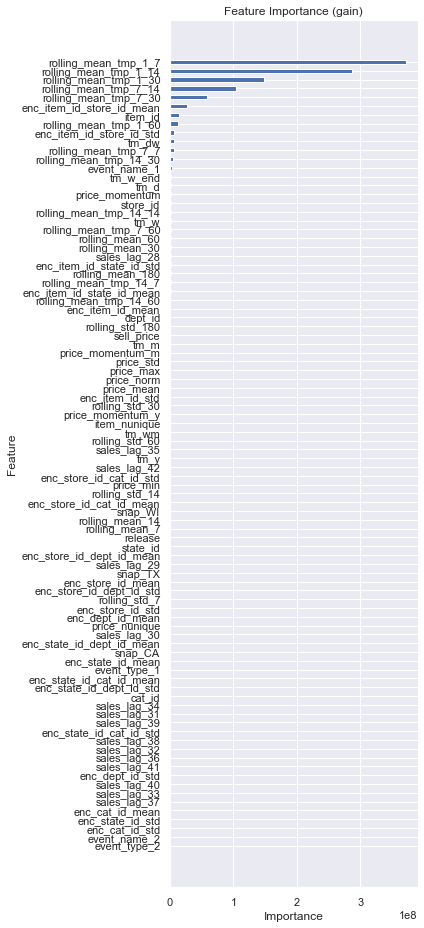

In [43]:
imp_type = "gain"
features = model.feature_name()
importances = model.feature_importance(imp_type)
_ = mplt.feature_importance(features, importances, imp_type)

In [44]:
importance_df=pd.DataFrame(features,columns=['features'])
importance_df['importances']=importances
importance_df=importance_df.sort_values(by='importances', ascending=False)
importance_df

,features,importances
37,rolling_mean_tmp_1_7,3.717718e+08
38,rolling_mean_tmp_1_14,2.875576e+08
39,rolling_mean_tmp_1_30,1.483968e+08
42,rolling_mean_tmp_7_14,1.038555e+08
43,rolling_mean_tmp_7_30,5.894730e+07
88,enc_item_id_store_id_mean,2.643948e+07
0,item_id,1.414816e+07
40,rolling_mean_tmp_1_60,1.287467e+07
89,enc_item_id_store_id_std,6.335746e+06
66,tm_dw,6.291514e+06
